# Spec2Vec - Find similar compounds for unknown substances
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

In [2]:
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile

from scipy import spatial

### Load filtered allGNPS_positive dataset OR:  Import& filter allGNPS_positive dataset

In [3]:
file_json = PATH_MS_DATA + "allGNPS_positive_minmax_10_1000_2dec_exp08_191115.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_191106.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


### Inspect spectra metadata

In [4]:
spectra_metadata.head()

,doc_ID,gnps_ID,name,title,precursor_mz,num_peaks_losses,inchi,inchikey,smiles,charge
0,0,CCMSLIB00005435503,chenodeoxycholic acid M-H2O+H,NaN,375.290,93,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-GYHJSIKNSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
1,1,CCMSLIB00005435504,chenodeoxycholic acid 2M+H,NaN,785.593,101,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
2,2,CCMSLIB00005435505,chenodeoxycholic acid 2M+Na,NaN,807.575,21,"""InChI=1S/C24H40O4/c1-14(4-7-21(27)28)17-5-6-1...",RUDATBOHQWOJDD-PODLAYBOSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,1
3,3,CCMSLIB00005435506,cholic acid M+Na,NaN,431.277,35,"""InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-1...",BHQCQFFYRZLCQQ-IHELEQLESA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1
4,4,CCMSLIB00005435507,deoxycholic acid M-H2O+H,NaN,375.289,157,"""InChI=1S/C24H40O4/c1-14(4-9-22(27)28)18-7-8-1...",KXGVEGMKQFWNSR-BKAWJTANSA-N,C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[...,1


### Count inchikey occurences

In [5]:
inchikeys_pd = spectra_metadata['inchikey'][spectra_metadata['inchikey'].notnull()]
inchikeys_pd.shape

(50195,)

In [6]:
inchikeys_pd.str[:14][-10:]

90216    CCQDWIRWKWIUKK
90217    RPVIQWDFJPYNJM
90218    BXEZTCOKOLHMKY
90219    BXEZTCOKOLHMKY
90220    PVXPPJIGRGXGCY
90221    ATEFPOUAMCWAQS
90222    ILEDWLMCKZNDJK
90223    ILEDWLMCKZNDJK
90224    NCJNNMWJQIKYLO
90225    LNCLTICCQWMCNS
Name: inchikey, dtype: object

### Get unique inchikeys (first 14 letters)

In [7]:
unique_inchikeys = inchikeys_pd.str[:14].unique()
unique_inchikeys.shape

(11011,)

In [8]:
inchikeys_pd.str[:14].head()

0    RUDATBOHQWOJDD
1    RUDATBOHQWOJDD
2    RUDATBOHQWOJDD
3    BHQCQFFYRZLCQQ
4    KXGVEGMKQFWNSR
Name: inchikey, dtype: object

### Randomly select 500 different inchikeys

In [9]:
num_spectra = 200

np.random.seed(42) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, num_spectra, replace=False)
selected_inchikeys[:25]

array(['BQYJATMQXGBDHF', 'LOVMOOUQHWMIHZ', 'VAFNMNRKDDAKRM',
       'VQQVWGVXDIPORV', 'LUJVUUWNAPIQQI', 'HJBUYKZTEBZNSH',
       'ZSJOCPIPUNPVFO', 'YXTROGRGRSPWKL', 'UOUFYEQUUCSLPP',
       'XOXHILFPRYWFOD', 'QFWCWMZSCXWBAK', 'QKEXQELISPDIMT',
       'OTXNTMVVOOBZCV', 'CUKXSBOAIJILRY', 'RSGRSUVVCYUKLM',
       'GSDSWSVVBLHKDQ', 'SITDJJDXDVFCAP', 'ZWJINEZUASEZBH',
       'RAGFPHFDFVNLCG', 'LETBAZLAGJPEIM', 'PJSKCCANFAFYHW',
       'VARCUXZWTHLZBR', 'TYNBQERPUSLOCV', 'VUFDXOACUHDTLI',
       'JDVVGAQPNNXQDW'], dtype=object)

### Pick ALL spectra for each of the chosen inchikeys

In [14]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

In [11]:
print(len(selected_spectra), "spectra were found with inchikeys from selected_inchikeys list.")

994 spectra were found with inchikeys from selected_inchikeys list.


In [12]:
# Show gnps IDs for selected spectra
spectra_metadata[["gnps_ID", "inchikey"]].loc[selected_spectra][:10]

,gnps_ID,inchikey
403,CCMSLIB00000579905,BQYJATMQXGBDHF-UHFFFAOYSA-N
1095,CCMSLIB00001058615,BQYJATMQXGBDHF-UHFFFAOYSA-N
1349,CCMSLIB00001058900,BQYJATMQXGBDHF-UHFFFAOYSA-N
1484,CCMSLIB00001059051,BQYJATMQXGBDHF-UHFFFAOYSA-N
26777,CCMSLIB00000212313,BQYJATMQXGBDHF-UHFFFAOYSA-N
26778,CCMSLIB00000212317,BQYJATMQXGBDHF-UHFFFAOYSA-N
26779,CCMSLIB00000212319,BQYJATMQXGBDHF-UHFFFAOYSA-N
26780,CCMSLIB00000212321,BQYJATMQXGBDHF-UHFFFAOYSA-N
26781,CCMSLIB00000212323,BQYJATMQXGBDHF-UHFFFAOYSA-N
26782,CCMSLIB00000212325,BQYJATMQXGBDHF-UHFFFAOYSA-N


### Show number of occurences of all selected inchikeys

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

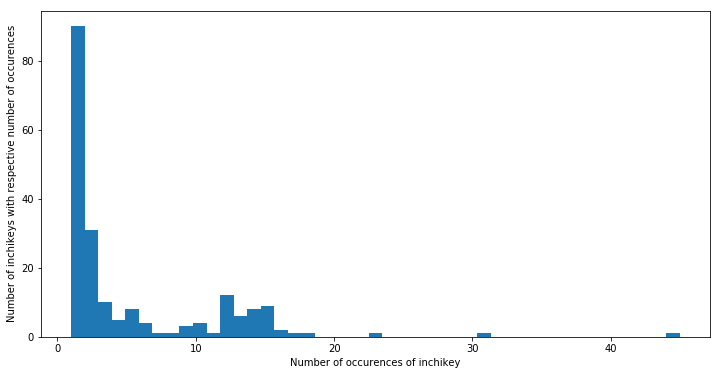

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts(), 45)
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

## Train new Spec2Vec model on dataset without the selected spectra
The aim here is to test how much Spec2Vec can potentially reveal about entirely unknown compounds. This means all spectra with identical inchikeys were removed, and the Spec2Vec model does not see them during training.

In [36]:
# Remove selected spectra from corpus
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)
print("Learning rate droped from", MS_measure.model_word2vec.alpha, "to", MS_measure.model_word2vec.min_alpha_yet_reached)

Modified corpus consists of 89232 documents.


Preprocess documents...
Number of unique words:  145568


No saved word2vec model found with given filename!
Calculating new word2vec model...
 Epoch 1 of 15.Change in loss after epoch 1: 6965052.0
 Epoch 2 of 15.Change in loss after epoch 2: 4970318.0
 Epoch 3 of 15.Change in loss after epoch 3: 4495444.0
 Epoch 4 of 15.Change in loss after epoch 4: 3737214.0
 Epoch 5 of 15.Change in loss after epoch 5: 3556258.0
 Epoch 6 of 15.Change in loss after epoch 6: 3440130.0
 Epoch 7 of 15.Change in loss after epoch 7: 3270988.0
 Epoch 8 of 15.Change in loss after epoch 8: 3154664.0
 Epoch 9 of 15.Change in loss after epoch 9: 1914572.0
 Epoch 10 of 15.Change in loss after epoch 10: 1871908.0
Saving model with name: C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\models_trained\S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_10.model
 Epoch 11 of 15.Change in loss after epoch 11: 1832752.0

In [14]:
# or load pretrained
MS_docs_removedpart = [MS_documents[x] for x in range(len(MS_documents)) if x not in selected_spectra]
MS_docs_intensity_removedpart = [MS_documents_intensity[x] for x in range(len(MS_documents)) if x not in selected_spectra]   
print("Modified corpus consists of", len(MS_docs_removedpart), "documents.")

MS_library = SimilarityMeasures(MS_docs_removedpart, MS_docs_intensity_removedpart)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

# Train new model based on reduced corpus
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_allGNPS_pos_unknownmatching_d300_w500_neg5_minmax10_1000_dec2_exp08_iter_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [10,5], 
                             use_stored_model=True)

Modified corpus consists of 89232 documents.
Preprocess documents...
Number of unique words:  145568
Load stored word2vec model ...


## Calculate Spec2Vec spectra vectors for all library spectra
This step will calculate the Spec2Vec vectors for all library spectra to later do comparisons with.

In [16]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  89232  of  89232  documents.ocuments. 89232  documents. 89232  documents. Calculated centroid vectors for  3380  of  89232  documents. 89232  documents.4280  of  89232  documents.  documents.5540  of  89232  documents. of  89232  documents.6150  of  89232  documents. 89232  documents.8380  of  89232  documents. of  89232  documents. Calculated centroid vectors for  8710  of  89232  documents.  of  89232  documents. 89232  documents.89232  documents.  of  89232  documents.10580  of  89232  documents.11450  of  89232  documents.  of  89232  documents. Calculated centroid vectors for  11730  of  89232  documents.13450  of  89232  documents.89232  documents. of  89232  documents. documents. of  89232  documents. 89232  documents.17610  of  89232  documents. 89232  documents.  of  89232  documents. 89232  documents. Calculated centroid vectors for  20550  of  89232  documents. of 

In [17]:
MS_library.vectors_centroid.shape[0]

89232

### Save MS_library object (including all computed S2V spectra vectors)

In [18]:
MS_library.save(PATH_COMPUTED + 'unkown_spectra_search_191202.obj')

### ... or load already built MS_library object:

In [16]:
MS_library = SimilarityMeasures([])
MS_library.load(PATH_COMPUTED + 'unkown_spectra_search_191202.obj')

### Select metadata for library spectra

In [17]:
library_spectra_IDs = [x for x in range(len(spectra)) if x not in selected_spectra]
library_spectra_metadata = spectra_metadata.loc[library_spectra_IDs]

library_spectra_metadata.shape

(89232, 10)

In [18]:
spectra_unknown = [spectra[x] for x in selected_spectra]
spectra_library = [spectra[x] for x in range(len(spectra)) if x not in selected_spectra]
len(spectra_unknown), len(spectra_library)

(994, 89232)

In [19]:
from MS_library_search import library_matching, vectorize_spectra

### Create spectrum vectors for the unkown spectra

In [20]:
spectra_vectors = vectorize_spectra(spectra_unknown,
                                      MS_library,
                                      num_decimals = 2,
                                      min_loss = 5.0, 
                                      max_loss = 500.0,
                                      peak_loss_words = ['peak_', 'loss_'],
                                      weighting_power = 0.5)

  Created documents for  994  of  994  spectra.
 ----------------------------------------
Not all 'words' of the given documents are present in the trained word2vec model!
33  out of  55496  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
----- Deriving Spec2Vec spectra vectors -----
  Calculated Spec2Vec spectra vectors for  994  of  994  documents. of  994  documents. of  994  documents.

In [21]:
spectra_vectors[:,:].shape, MS_library.vectors_centroid.shape

((994, 300), (89232, 300))

## Search for potential spectra matches
This will create a table with potential matches based on precursor mass (using different m/z tolerances as given in mz_ppm), and based on Spec2Vec.

In [22]:
found_matches = library_matching(spectra_unknown, 
                                  spectra_library,
                                  library_spectra_metadata, 
                                  MS_library, 
                                  top_n = 10,
                                  mz_ppm = [2, 10, 20],
                                  spectra_vectors = spectra_vectors,
                                  ignore_non_annotated = True,
                                  cosine_tol = 0.05)

Spec2Vec spectra vectors found for library data.


In [23]:
found_matches[20]

,spectra_ID,inchikey_copies,mass_match_20ppm,S2V_top_n,S2V_similarity,inchikey_match,mass_match_10ppm,mass_match_2ppm,cosine_score,cosine_matches,modcosine_score,modcosine_matches
0,23340,1,1,0,0.051690,0,0,0,0.002875,4,0.002875,4
1,23343,1,1,0,0.019012,0,0,0,0.002822,1,0.002822,2
2,41399,12,1,0,0.325432,0,1,1,0.448070,62,0.448070,62
3,41400,12,1,0,0.287618,0,1,1,0.226859,53,0.226859,53
4,41401,12,1,0,0.154804,0,1,1,0.017466,40,0.017466,40
5,45803,10,1,0,0.113358,0,1,1,0.003076,14,0.003076,14
6,45804,10,1,0,0.141269,0,1,1,0.000650,9,0.000650,9
7,45805,10,1,0,0.119852,0,1,1,0.000212,7,0.000212,7
8,36270,3,0,1,0.827930,0,0,0,0.944868,56,0.950152,56
9,36517,10,0,1,0.698194,0,0,0,0.528813,48,0.532418,48


In [24]:
ID = 20#80

match_IDs = found_matches[ID][found_matches[ID]['mass_match_10ppm']==1]['spectra_ID'].values.tolist()
[spectra_library[x].inchikey for x in match_IDs]

['BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'BMKQPAJRQUUYGC-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N',
 'DDNPCXHBFYJXBJ-UHFFFAOYSA-N']

## Collect all top-10 matches based on Spec2Vec similarity

In [25]:
mol_sim_matches = []
list_sv2 = []
list_modcos = []
list_copies = []

for ID in range(len(spectra_unknown)):
    idx = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)].index.tolist()

    match_IDs = found_matches[ID].loc[idx]['spectra_ID'].values.tolist()
    
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches.append(Mtest)

        list_sv2.append(found_matches[ID].loc[idx]['S2V_similarity'].values.tolist())
        list_modcos.append(found_matches[ID].loc[idx]['modcosine_score'].values.tolist())
        list_copies.append(found_matches[ID].loc[idx]['inchikey_copies'].values.tolist())

No proper molecule generated for spectrum 4
Problem with molecule from spectrum 4
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 2
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 2
No proper molecule generated for spectrum 2
No proper molecule generated for spectrum 3
Problem with molecule from spectrum 2
Problem with molecule from spectrum 3
No proper molecule generated for spectrum 7
No proper molecule generated for spectrum 9
Problem with molecule from spectrum 7
Problem with molecule from spectrum 9


In [26]:
mol_sim_matches_s2v_arr = np.array(mol_sim_matches)
np.mean(np.nan_to_num(mol_sim_matches_s2v_arr), axis = 0)

array([[0.51729461, 0.50599717, 0.47731045, 0.47588897, 0.46183964,
        0.45303783, 0.45209716, 0.43545794, 0.4270291 , 0.43646117]])

In [27]:
mol_sim_matches_s2v_arr.shape

(994, 1, 10)

## Plot molecular similarities of "best Spec2Vec pick" for all found candidates

In [80]:
def histogram_found_matches(matches,
                            n_bins,
                            method = "ideal_pick",
                            sort_by_lst = None,
                            filename = None):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0,1,n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(6,5))
    
    if method == "ideal_pick": 
        # Chose best pick from condidate suggestions
        hist, bin_edges = np.histogram(np.max(matches, axis=2), bins_lst)
    elif method == 'argmax':
        if sort_by_lst is None:
            print("sort_by_lst list expected.")
        nums = len(matches)
        pick = []
        for i in range(nums):
            pick += [np.array(sort_by_lst[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    #plt.xlabel('best found molecular similarity among Spec2Vec top-10 suggestions \n (rdkit-2048 fingerprint --> jaccard score)')
    plt.yticks(10*np.arange(4), ('0', '10', '20', '30'), fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of matches [%]', fontsize=16)
    
    if filename is not None:
        plt.savefig(filename)
        
    return hist, bin_edges

[193 247 144 135 275]


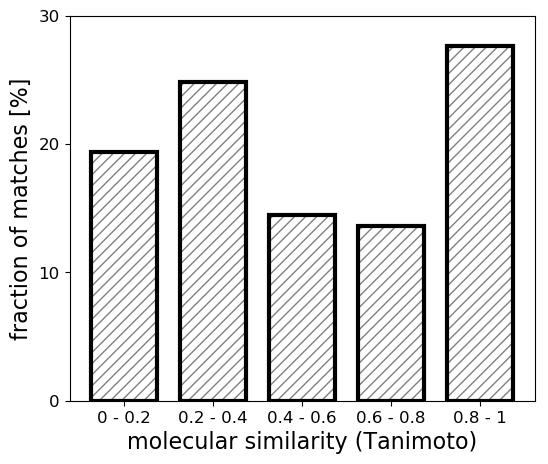

In [36]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 
                                          5,
                                           'argmax',
                                           list_modcos)
print(hist)

In [ ]:
mol_sim_matches_s2v_arr

## Plot molecular similarities of only the actual best of the top-10 found candidates
This is not reflecting a real-case scenario where the molecular similarities are unkown.  
However, it represents what a manual inspection of the top-10 candidates might be able to reveal.

[ 60 207 162 160 405]


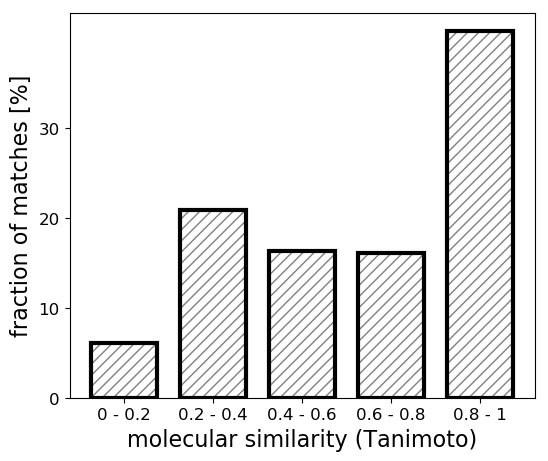

In [38]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5,
                                          'ideal_pick',
                                          sort_by_lst = None,
                                          filename = 'histogram_quality_of_found_matches.pdf')
print(hist)

[ 11  49  86 121  79  84  60  99  80 325] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


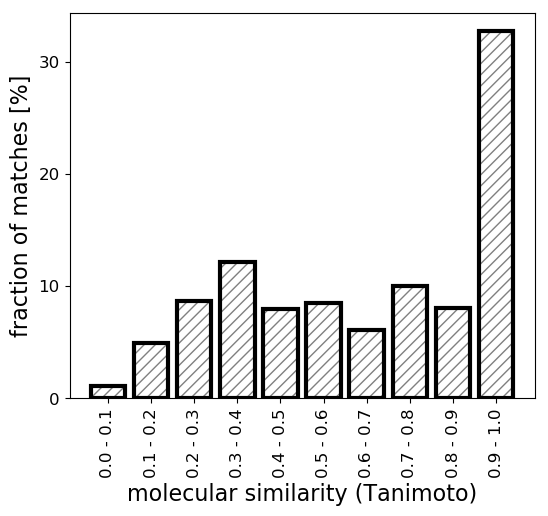

In [56]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 10,
                                          'ideal_pick',
                                          sort_by_lst = None)
print(hist, bin_edges)

In [65]:
good_bad = 0.4
idx = np.where(bin_edges[1:] > good_bad)[0]
print("Good matches found (>"+str(good_bad)+"):", np.sum(np.array(hist)[idx]))
idx = np.where(bin_edges[1:] <= good_bad)[0]     
print("Poor matches found (<="+str(good_bad)+"):", np.sum(np.array(hist)[idx]))

Good matches found (>0.4): 727
Poor matches found (<=0.4): 267


## Search based on S2V only

In [84]:
# parameter:
acceptable_s2v = 0.6

mol_sim_matches_s2v_thres = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > acceptable_s2v)]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches_s2v_thres.append(Mtest)

No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 2
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 2


In [85]:
mol_sim_matches_s2v_thres[1].argmax()

2

In [86]:
np.array([x[0][0] for x in mol_sim_matches_s2v_thres]).shape

(699,)

In [87]:
print("Found matches for", len(mol_sim_matches_s2v_thres), 
      "spectra out of", len(spectra_unknown), "spectra in total.")

print("Good matches found (>0.5):", np.sum(np.array([x[0][0] for x in mol_sim_matches_s2v_thres]) > 0.5))
print("Poor matches found (<=0.5):", np.sum(np.array([x[0][0] for x in mol_sim_matches_s2v_thres]) <= 0.5))

Found matches for 699 spectra out of 994 spectra in total.
Good matches found (>0.5): 361
Poor matches found (<=0.5): 338


In [88]:
print("Mean molecular similarity:", np.mean([x[0][0] for x in mol_sim_matches_s2v_thres]))

Mean molecular similarity: 0.5494145527725738


[ 14  53  56  74  44  48  49  76  52 233] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


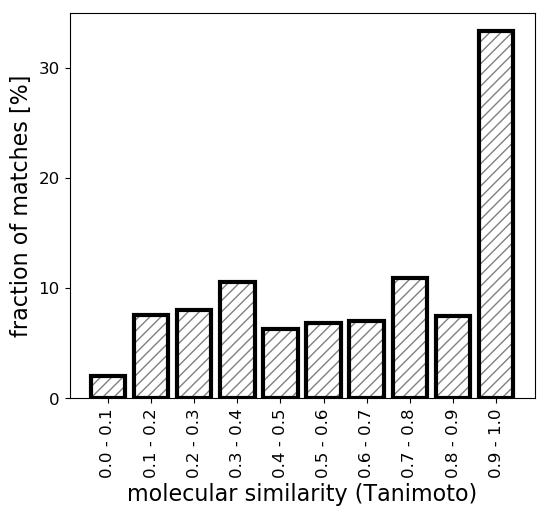

In [89]:
hist, bin_edges = histogram_found_matches(mol_sim_matches_s2v_thres, 10,
                                          'argmax',
                                          sort_by_lst = mol_sim_matches_s2v_thres)
print(hist, bin_edges)

In [90]:
good_bad = 0.4
idx = np.where(bin_edges[1:] > good_bad)[0]
print("Good matches found (>"+str(good_bad)+"):", np.sum(np.array(hist)[idx]))
idx = np.where(bin_edges[1:] <= good_bad)[0]     
print("Poor matches found (<="+str(good_bad)+"):", np.sum(np.array(hist)[idx]))

Good matches found (>0.4): 502
Poor matches found (<=0.4): 197


Text(0, 0.5, 'number of matches')

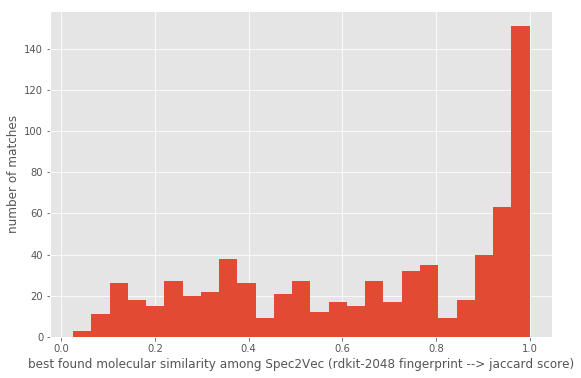

In [70]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(np.array([max(x[0]) for x in mol_sim_matches_s2v_thres]), 25)
plt.xlabel('best found molecular similarity among Spec2Vec (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

In [157]:
print("Good matches found (>0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches_s2v_thres]) > 0.5))
print("Poor matches found (<=0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches_s2v_thres]) <= 0.5))

Good matches found (>0.5): 454
Poor matches found (<=0.5): 245


## Search based on S2V and other factors...

### Search including S2V and mod.cosine scores (both must be high...)

In [180]:
# parameter:
acceptable_s2v = 0.7
acceptable_modcos = 0.7

mol_sim_matches = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > acceptable_s2v)
                                  & (found_matches[ID]['modcosine_score'] > acceptable_modcos)]['spectra_ID'].values.tolist()
                                  #& (found_matches[ID]['inchikey_copies'] > 5)]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches.append(Mtest)

In [181]:
print("Found matches for", len(mol_sim_matches), 
      "spectra out of", len(spectra_unknown), "spectra in total.")

print("Good matches found (>0.5):", np.sum(np.array([x[0][0] for x in mol_sim_matches]) > 0.5))
print("Poor matches found (<=0.5):", np.sum(np.array([x[0][0] for x in mol_sim_matches]) <= 0.5))

Found matches for 373 spectra out of 994 spectra in total.
Good matches found (>0.5): 221
Poor matches found (<=0.5): 152


In [182]:
print("Mean molecular similarity:", np.mean([x[0][0] for x in mol_sim_matches]))

Mean molecular similarity: 0.6062970814464564


Text(0, 0.5, 'number of matches')

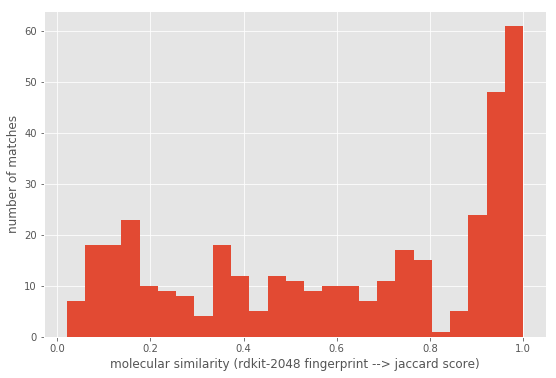

In [183]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(np.array([x[0][0] for x in mol_sim_matches]), 25)
plt.xlabel('molecular similarity (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

### Pick best actual candidate from top-10 suggestions

Text(0, 0.5, 'number of matches')

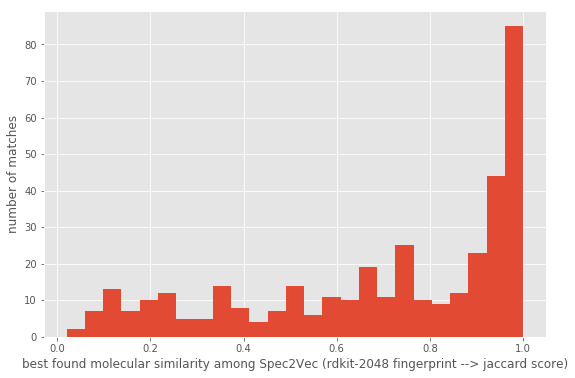

In [184]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(np.array([max(x[0]) for x in mol_sim_matches]), 25)
plt.xlabel('best found molecular similarity among Spec2Vec (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

In [185]:
print("Good matches found (>0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) > 0.5))
print("Poor matches found (<=0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) <= 0.5))

Good matches found (>0.5): 271
Poor matches found (<=0.5): 102


## For comparison: what are mol.simularities for random selection?

In [325]:

np.random.seed(42)
random_ID = np.random.choice(np.arange(len(spectra_unknown)),100)
random_ID_2 = np.random.choice(np.arange(len(spectra_library)),10 * 100)

mol_sim_matches = []

for i in range(100):
    match_IDs = random_ID_2[i*10:(i*10+10)]
    ID = random_ID[i]
    
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches.append(Mtest)

No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 6
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 3
Problem with molecule from spectrum 5
Problem with molecule from spectrum 6
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 6
No proper molecule generated for spectrum 7
No proper molecule generated for spectrum 9
Problem with molecule from spectrum 1
Problem with molecule from spectrum 5
Problem with molecule from spectrum 6
Problem with molecule from spectrum 7
Problem with molecule from spectrum 9
No proper molecu

Problem with molecule from spectrum 1
Problem with molecule from spectrum 4
Problem with molecule from spectrum 5
Problem with molecule from spectrum 7
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 8
Problem with molecule from spectrum 5
Problem with molecule from spectrum 8
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 2
No proper molecule generated for spectrum 7
No proper molecule generated for spectrum 9
Problem with molecule from spectrum 0
Problem with molecule from spectrum 2
Problem with molecule from spectrum 7
Problem with molecule from spectrum 9
No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 9
Problem with molecule from spectrum 3
Problem with molecule from spectrum 5
Problem with molecule from spectrum 9
No proper molecule generated for spectrum 4
No proper molecule generated for spectrum 7
No proper molecule gen

Problem with molecule from spectrum 6
Problem with molecule from spectrum 7
Problem with molecule from spectrum 8
Problem with molecule from spectrum 9
No proper molecule generated for spectrum 2
No proper molecule generated for spectrum 4
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 7
Problem with molecule from spectrum 2
Problem with molecule from spectrum 4
Problem with molecule from spectrum 5
Problem with molecule from spectrum 7
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 6
No proper molecule generated for spectrum 7
No proper molecule generated for spectrum 8
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 3
Problem with molecule from spectrum 6
Problem with molecule from spectrum 7
Problem with molecule from spectrum 8
No proper molecule generated

Problem with molecule from spectrum 2
Problem with molecule from spectrum 3
Problem with molecule from spectrum 6
Problem with molecule from spectrum 8
Problem with molecule from spectrum 9
No proper molecule generated for spectrum 1
Problem with molecule from spectrum 1
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 2
No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 4
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 6
No proper molecule generated for spectrum 8
Problem with molecule from spectrum 0
Problem with molecule from spectrum 2
Problem with molecule from spectrum 3
Problem with molecule from spectrum 4
Problem with molecule from spectrum 5
Problem with molecule from spectrum 6
Problem with molecule from spectrum 8
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 4
No proper molecule generated for spectrum 5
No proper molecule gen

No proper molecule generated for spectrum 8
Problem with molecule from spectrum 6
Problem with molecule from spectrum 7
Problem with molecule from spectrum 8
No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 6
No proper molecule generated for spectrum 8
No proper molecule generated for spectrum 9
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 3
Problem with molecule from spectrum 5
Problem with molecule from spectrum 6
Problem with molecule from spectrum 8
Problem with molecule from spectrum 9


In [329]:
mol_sim_matches[:2]

[array([[0.        , 0.        , 0.13891726, 0.05349794, 0.18943089,
         0.2217484 , 0.2738676 , 0.27395412, 0.27296417, 0.28678118]]),
 array([[0.        , 0.        , 0.11969697, 0.        , 0.13126761,
         0.        , 0.        , 0.12215321, 0.10433884, 0.35483871]])]

In [355]:
test = np.array([x[0,:] for x in mol_sim_matches])
test[test>0][:100]

array([0.13891726, 0.05349794, 0.18943089, 0.2217484 , 0.2738676 ,
       0.27395412, 0.27296417, 0.28678118, 0.11969697, 0.13126761,
       0.12215321, 0.10433884, 0.35483871, 0.15384615, 0.52958153,
       0.11245675, 0.23003195, 0.10692771, 0.24435484, 0.12758621,
       0.08944544, 0.28343313, 0.18998273, 0.1826087 , 0.44969819,
       0.15894737, 0.22103004, 0.07564103, 0.13340807, 0.19727891,
       0.36178344, 0.11042184, 0.1302682 , 0.19625   , 0.15420561,
       0.09577922, 0.39988152, 0.26974952, 0.38127295, 0.33639144,
       0.35392921, 0.05527994, 0.35289515, 0.27556512, 0.26770538,
       0.24849095, 0.33431373, 0.69936709, 0.4162473 , 0.18575293,
       0.35545024, 0.48348348, 0.16393443, 0.16895874, 0.17230769,
       0.16782407, 0.05894309, 0.25      , 0.12864078, 0.22873194,
       0.25503778, 0.25378788, 0.17576318, 0.25235849, 0.32728495,
       0.24206642, 0.4594438 , 0.30996564, 0.1876466 , 0.33377483,
       0.14895947, 0.09162717, 0.5032538 , 0.18655589, 0.23637

Text(0, 0.5, 'number of matches')

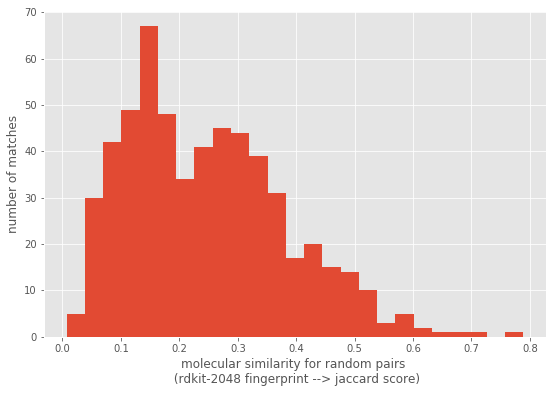

In [363]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(test[test>0], 25)
plt.xlabel('molecular similarity for random pairs \n (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

## Search including S2V and mod.cosine scores (at least one must be high...)

In [292]:
# parameter:
acceptable_s2v = 0.6
acceptable_modcos = 0.8

mol_sim_matches = []
list_sv2 = []
list_modcos = []
list_copies = []

for ID in range(len(spectra_unknown)):
    idx = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & ((found_matches[ID]['S2V_similarity'] > acceptable_s2v)
                                  | (found_matches[ID]['modcosine_score'] > acceptable_modcos))].index.tolist()
                                  #& (found_matches[ID]['inchikey_copies'] >= min_copies)].index.tolist()
    match_IDs = found_matches[ID].loc[idx]['spectra_ID'].values.tolist()
    
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches.append(Mtest)

        list_sv2.append(found_matches[ID].loc[idx]['S2V_similarity'].values.tolist())
        list_modcos.append(found_matches[ID].loc[idx]['modcosine_score'].values.tolist())
        list_copies.append(found_matches[ID].loc[idx]['inchikey_copies'].values.tolist())

No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 2
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 2


### select from top-1o list, e.g. based on modcos

In [299]:
best_pick = []
for i, sv2 in enumerate(list_sv2):
    #best_pick += [(np.array(sv2) * np.array(list_modcos[i]) * np.log(np.array([list_copies[i]])+1)).argmax()]
    best_pick += [(0*np.array(sv2) + np.array(list_modcos[i])).argmax()]

In [300]:
good_bad = 0.4

print("Found matches for", len(mol_sim_matches), 
      "spectra out of", len(spectra_unknown), "spectra in total.")

nums = len(mol_sim_matches)
print("Sort top10 by s2v + modcos:")
print("Good matches found (>"+str(good_bad)+":", np.sum(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]) > good_bad))
print("Poor matches found (<="+str(good_bad)+":", np.sum(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]) <= good_bad))
print("Mean molecular similarity:", np.mean([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]))
print("\n Sort top10 by s2v only:")
print("Good matches found (>"+str(good_bad)+":", np.sum(np.array([x[0][0] for x in mol_sim_matches]) > good_bad))
print("Poor matches found (<="+str(good_bad)+":", np.sum(np.array([x[0][0] for x in mol_sim_matches]) <= good_bad))
print("Mean molecular similarity:", np.mean([x[0][0] for x in mol_sim_matches]))

Found matches for 775 spectra out of 994 spectra in total.
Sort top10 by s2v + modcos:
Good matches found (>0.5): 429
Poor matches found (<=0.5): 346
Mean molecular similarity: 0.5701088156179014

 Sort top10 by s2v only:
Good matches found (>0.5): 392
Poor matches found (<=0.5): 383
Mean molecular similarity: 0.5447613701466203


Text(0, 0.5, 'number of matches')

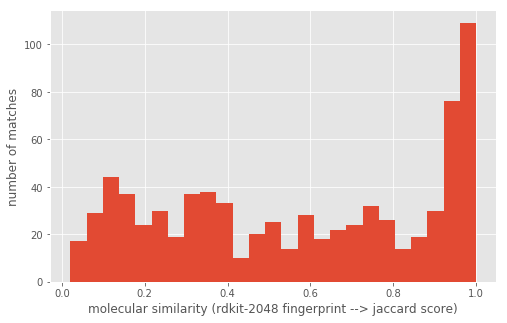

In [302]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]), 25)
plt.xlabel('molecular similarity (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

### Pick best actual candidate from top-10 suggestions

Text(0, 0.5, 'number of matches')

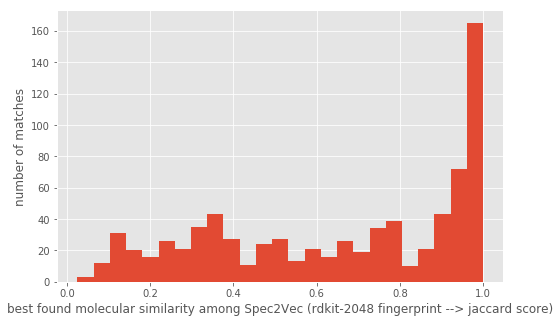

In [303]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(np.array([max(x[0]) for x in mol_sim_matches]), 25)
plt.xlabel('best found molecular similarity among Spec2Vec (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

In [304]:
print("Good matches found (>0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) > 0.5))
print("Poor matches found (<=0.5):", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) <= 0.5))

Good matches found (>0.5): 497
Poor matches found (<=0.5): 278


## Search including S2V and mod.cosine scores (at least one must be very high...)

In [392]:
# parameter:
acceptable_s2v = 0.7
acceptable_modcos = 0.85

mol_sim_matches = []
list_sv2 = []
list_modcos = []
list_copies = []

for ID in range(len(spectra_unknown)):
    idx = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & ((found_matches[ID]['S2V_similarity'] > acceptable_s2v)
                                  | (found_matches[ID]['modcosine_score'] > acceptable_modcos))].index.tolist()
                                  #& (found_matches[ID]['inchikey_copies'] >= min_copies)].index.tolist()
    match_IDs = found_matches[ID].loc[idx]['spectra_ID'].values.tolist()
    
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches.append(Mtest)

        list_sv2.append(found_matches[ID].loc[idx]['S2V_similarity'].values.tolist())
        list_modcos.append(found_matches[ID].loc[idx]['modcosine_score'].values.tolist())
        list_copies.append(found_matches[ID].loc[idx]['inchikey_copies'].values.tolist())

No proper molecule generated for spectrum 0
Problem with molecule from spectrum 0


### select from top-1o list, e.g. based on modcos

In [393]:
best_pick = []
for i, sv2 in enumerate(list_sv2):
    best_pick += [np.array(list_modcos[i]).argmax()]

In [403]:
good_bad = 0.4

print("Found matches for", len(mol_sim_matches), 
      "spectra out of", len(spectra_unknown), "spectra in total.")

nums = len(mol_sim_matches)
print("Sort top10 by s2v + modcos:")
print("Good matches found (>"+str(good_bad)+":", np.sum(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]) > good_bad))
print("Poor matches found (<="+str(good_bad)+":", np.sum(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]) <= good_bad))
print("Mean molecular similarity:", np.mean([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]))
print("\n Sort top10 by s2v only:")
print("Good matches found (>"+str(good_bad)+":", np.sum(np.array([x[0][0] for x in mol_sim_matches]) > good_bad))
print("Poor matches found (<="+str(good_bad)+":", np.sum(np.array([x[0][0] for x in mol_sim_matches]) <= good_bad))
print("Mean molecular similarity:", np.mean([x[0][0] for x in mol_sim_matches]))

Found matches for 607 spectra out of 994 spectra in total.
Sort top10 by s2v + modcos:
Good matches found (>0.4: 391
Poor matches found (<=0.4: 216
Mean molecular similarity: 0.5896905432190563

 Sort top10 by s2v only:
Good matches found (>0.4: 361
Poor matches found (<=0.4: 246
Mean molecular similarity: 0.5579333715615429


Text(0, 0.5, 'number of matches')

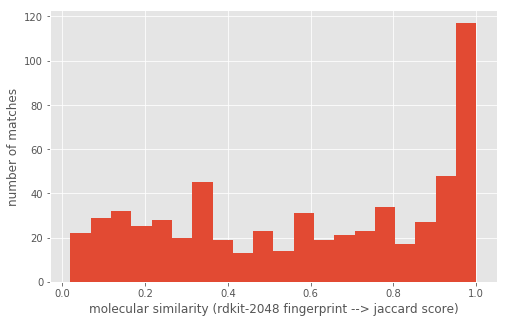

In [400]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(np.array([mol_sim_matches[i][0][best_pick[i]] for i in range(nums)]), 20)
plt.xlabel('molecular similarity (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

### Pick best actual candidate from top-10 suggestions

Text(0, 0.5, 'number of matches')

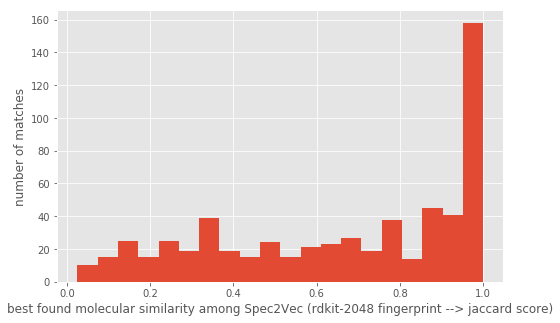

In [397]:
plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.hist(np.array([max(x[0]) for x in mol_sim_matches]), 20)
plt.xlabel('best found molecular similarity among Spec2Vec (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

In [404]:
print("Good matches found (>"+str(good_bad)+":", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) > good_bad))
print("Poor matches found (<="+str(good_bad)+":", np.sum(np.array([max(x[0]) for x in mol_sim_matches]) <= good_bad))

Good matches found (>0.4: 447
Poor matches found (<=0.4: 160


## Use precursor mz to search similar spectra

In [101]:
mol_sim_matches_mass = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][found_matches[ID]['mass_match_10ppm']==1]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches_mass.append(Mtest)

No proper molecule generated for spectrum 3
No proper molecule generated for spectrum 4
No proper molecule generated for spectrum 5
No proper molecule generated for spectrum 6
Problem with molecule from spectrum 3
Problem with molecule from spectrum 4
Problem with molecule from spectrum 5
Problem with molecule from spectrum 6


In [102]:
print("Found matches for", len(mol_sim_matches_mass), "spectra out of", len(spectra_unknown), "spectra in total.")

Found matches for 617 spectra out of 994 spectra in total.


In [103]:
mol_sim_matches_mass_mean = np.zeros((10))
mol_sim_matches_mass_counts = np.zeros((10))
top1_lst = []

for matches in mol_sim_matches_mass:
    matches = np.nan_to_num(matches[0])
    high = min(len(matches),10)
    if high > 0:
        top1_lst.append(matches[0])
        mol_sim_matches_mass_mean[:high] = mol_sim_matches_mass_mean[:high] + np.array(matches[:high])
        mol_sim_matches_mass_counts[:high] = mol_sim_matches_mass_counts[:high] + np.ones(high)

mol_sim_matches_mass_arr1 = np.array(top1_lst)    
    
mol_sim_matches_mass_mean/mol_sim_matches_mass_counts

array([0.46958705, 0.4591534 , 0.46448891, 0.47239599, 0.45815543,
       0.48435784, 0.51347674, 0.48661704, 0.47868342, 0.48633372])

Text(0, 0.5, 'number of matches')

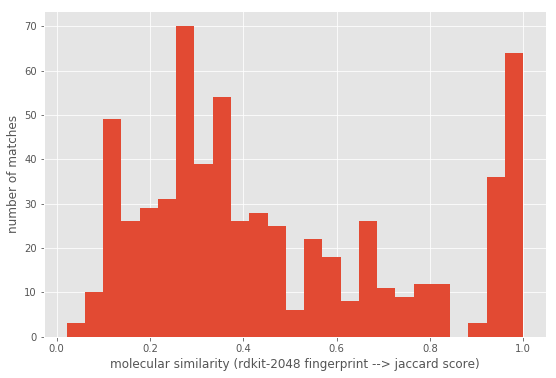

In [164]:
plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.hist(mol_sim_matches_mass_arr1, 25)
plt.xlabel('molecular similarity (rdkit-2048 fingerprint --> jaccard score)')
plt.ylabel('number of matches')

## Same for morgan3 fingerprints and cosine similarity

(array([ 44.,  69., 116.,  64.,  63.,  16.,  25.,  10.,  30.,  21.,  29.,
          8.,   1.,   9.,   1.,   9.,   6.,  47.,  18.,   0.,   2.,   3.,
          1.,   9.,  16.]),
 array([0.06745406, 0.10432808, 0.1412021 , 0.17807612, 0.21495013,
        0.25182415, 0.28869817, 0.32557219, 0.3624462 , 0.39932022,
        0.43619424, 0.47306826, 0.50994228, 0.54681629, 0.58369031,
        0.62056433, 0.65743835, 0.69431236, 0.73118638, 0.7680604 ,
        0.80493442, 0.84180843, 0.87868245, 0.91555647, 0.95243049,
        0.98930451]),
 <a list of 25 Patch objects>)

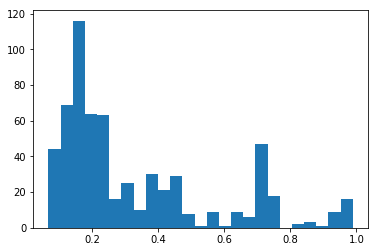

In [32]:
plt.hist(mol_sim_matches_mass_arr1, 25)

## Search for both mass and S2V score

In [106]:
mol_sim_matches_mass_s2vmodcos = []

for ID in range(len(spectra_unknown)):
    match_IDs = found_matches[ID][((found_matches[ID]['mass_match_10ppm']==1)
                                 & (found_matches[ID]['modcosine_score'] > 0.5))
                                 | ((found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.6))]['spectra_ID'].values.tolist()
    if len(match_IDs) > 0:
        fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
        fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",  
                                                                 nBits = 2048,
                                                                 print_progress = False)

        # calculate similarities
        Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                               fingerprint_matches,
                                               method = 'jaccard',
                                               filename = None,
                                               max_size = 1000,
                                               print_progress = False)

        mol_sim_matches_mass_s2vmodcos.append(Mtest)

No proper molecule generated for spectrum 0
No proper molecule generated for spectrum 1
No proper molecule generated for spectrum 2
Problem with molecule from spectrum 0
Problem with molecule from spectrum 1
Problem with molecule from spectrum 2


In [110]:
mol_sim_matches_mass_s2vmodcos_mean = np.zeros((10))
mol_sim_matches_mass_s2vmodcos_counts = np.zeros((10))
top1_lst = []

for matches in mol_sim_matches_mass_s2vmodcos:
    matches = np.nan_to_num(matches[0])
    high = min(len(matches),10)
    if high > 0:
        top1_lst.append(matches[0])
        mol_sim_matches_mass_s2vmodcos_mean[:high] = mol_sim_matches_mass_s2vmodcos_mean[:high] + np.array(matches[:high])
        mol_sim_matches_mass_s2vmodcos_counts[:high] = mol_sim_matches_mass_s2vmodcos_counts[:high] + np.ones(high)

mol_sim_matches_mass_s2vmodcos_arr1 = np.array(top1_lst)    
    
mol_sim_matches_mass_s2vmodcos_mean/mol_sim_matches_mass_s2vmodcos_counts

array([0.55602125, 0.54701678, 0.51963064, 0.50768641, 0.50288268,
       0.50292098, 0.49342038, 0.47766954, 0.46776428, 0.48075081])

(array([ 10.,  22.,  36.,  53.,  31.,  24.,  29.,  18.,  41.,  29.,  15.,
         16.,  29.,  16.,  15.,  12.,  21.,  24.,  15.,  39.,  10.,  10.,
         37.,  62., 107.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <a list of 25 Patch objects>)

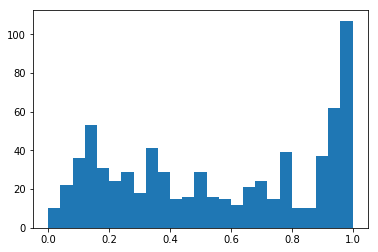

In [111]:
plt.hist(mol_sim_matches_mass_s2vmodcos_arr1, 25)

## Same search but compared to morgan3 fingerprints + cosine similarity

(array([ 8., 20., 32., 55., 50., 46., 30., 37., 51., 27., 19., 18., 19.,
        22., 19., 18., 18., 34., 54., 17., 20., 47.,  7., 12., 24.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <a list of 25 Patch objects>)

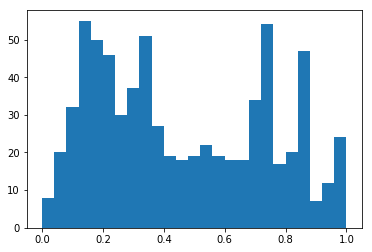

In [38]:
plt.hist(np.array([x[0][0] for x in mol_sim_matches_s2v_thres]), 25)

In [39]:
ID = 80
match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.5)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]['spectra_ID'].values.tolist()
match_IDs

[29762]

In [41]:
ID = 100

match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.5)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]['spectra_ID'].values.tolist()
if len(match_IDs) > 0:
    print("Query spectra ----------------", '\n',
          "SMILES:", spectra_unknown[ID].smiles, '\n',
          "INCHIKEY:", spectra_unknown[ID].inchikey, '\n',
          "TITLE:", spectra_unknown[ID].metadata['title'])
    print("Proposed similar spectra ----------------", '\n',
          "SMILES:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].smiles, '\n',
          "INCHIKEY:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].inchikey, '\n',
         "TITLE:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].metadata['title'])

Query spectra ---------------- 
 SMILES: [H][C@]1(CC(/C=C/C)=CN21)C(O)NC3=C(O)C(C)=C(O[C@@H]4O[C@@H](C)[C@H](NC)[C@@](C)(O)[C@H]4O)C=C3C2=O 
 INCHIKEY: RAGFPHFDFVNLCG-OKNUHWCXSA-N 
 TITLE: Sibiromycin hemiaminal
Proposed similar spectra ---------------- 
 SMILES: [H][C@]1(CC(CCCC)CN21)C(O)NC3=C(O)C(C)=C(O[C@@H]4O[C@@H](C)[C@H](NC)[C@@](C)(O)[C@H]4O)C=C3C2=O 
 INCHIKEY: YWAXVDLXUXRDHL-NLUDKXEPSA-N 
 TITLE: Sibiromycin-494 hemiaminal


In [42]:
ID = 140

match_IDs = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.5)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]['spectra_ID'].values.tolist()
if len(match_IDs) > 0:
    print("Query spectra ----------------", '\n',
          "SMILES:", spectra_unknown[ID].smiles, '\n',
          "INCHIKEY:", spectra_unknown[ID].inchikey, '\n',
          "TITLE:", spectra_unknown[ID].metadata['title'])
    print("Proposed similar spectra ----------------", '\n',
          "SMILES:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].smiles, '\n',
          "INCHIKEY:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].inchikey, '\n',
         "TITLE:", spectra[library_spectra_metadata.iloc[match_IDs].index[0]].metadata['title'])


Query spectra ---------------- 
 SMILES: CC(=CCCC(C)([C@H]1CC[C@]2(C)[C@@H]1[C@@H](CC1[C@@]3(C)CC[C@@H](C(C)(C)[C@@H]3CC[C@@]21C)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)O)O)O)C 
 INCHIKEY: RWXIFXNRCLMQCD-XXYKJBRESA-N 
 TITLE: (2S,3R,4S,5S,6R)-2-[(2R,3R,4S,5S,6R)-4,5-dihydroxy-2-[[(3S,5R,8R,10R,12R,13R,14R,17S)-12-hydroxy-17-(2-hydroxy-6-methylhept-5-en-2-yl)-4,4,8,10,14-pentamethyl-2,3,5,6,7,9,11,12,13,15,16,17-dodecahydro-1H-cyclopenta[a]phenanthren-3-yl]oxy]-6-(hydroxymethyl)oxan-3-yl]oxy-6-(hydroxymethyl)oxane-3,4,5-triol
Proposed similar spectra ---------------- 
 SMILES: CC(=CCC[C@@](C)([C@H]1CC[C@]2(C)[C@@H]1[C@@H](CC1[C@@]3(C)CC[C@@H](C(C)(C)[C@@H]3[C@H](C[C@@]21C)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](CO)O1)O)O)O)O)O)O)C 
 INCHIKEY: UZIOUZHBUYLDHW-KIOKIGKZSA-N 
 TITLE: (2S,3R,4S,5S,6R)-2-[(2R,3R,4S,5S,6R)-2-[[(3S,5R,6S,8R,10R,12R,13R,14R,17S)-3,12-dihydroxy-17-[(2S)-2-hydroxy-6-methylhept-5-e

## Inspect results

In [309]:
from rdkit import Chem
from rdkit.Chem import Draw

In [42]:
#!scour -i draw_mols2.svg -o draw_mols2corr.svg

Scour processed file "draw_mols2.svg" in 31 ms: 6530/9757 bytes new/orig -> 66.9%


In [310]:
from IPython.display import SVG, display

def plot_molecule(smiles_lst):
    if not isinstance(smiles_lst, list):
        smiles_lst = [smiles_lst]
    for smiles in smiles_lst:
        filename = "draw_mols_temp.svg"
        mol = Chem.MolFromSmiles(smiles)
        Draw.MolToFile(mol, filename)
        !scour -i draw_mols_temp.svg -o draw_mols_temp_corr.svg

        display(SVG(filename='draw_mols_temp_corr.svg'))

In [311]:
plot_molecule("[H][C@]1(CC(/C=C/C)=CN21)C(O)NC3=C(O)C(C)=C(O[C@@H]4O[C@@H](C)[C@H](NC)[C@@](C)(O)[C@H]4O)C=C3C2=O")

Traceback (most recent call last):
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\Scripts\scour.exe\__main__.py", line 9, in <module>
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\site-packages\scour\scour.py", line 3979, in run
    start(options, input, output)
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\site-packages\scour\scour.py", line 3947, in start
    out_string = scourString(in_string, options).encode("UTF-8")
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\site-packages\scour\scour.py", line 3439, in scourString
    doc = xml.dom.minidom.parseString(in_string)
  File "c:\users\florianhuber\anaconda3\envs\sesime\lib\xml\dom\minidom.py", line 1968, in parseString
    return expatbuilder.parseString(string

ExpatError: no element found: line 1, column 0

In [35]:
library_spectra_metadata.iloc[matchID][0]

46865

In [56]:
match_IDs

[5157]

# Display potentially similar compounds to unknown spectra

In [377]:
match_IDs, match_modcos_scores

([36413, 54323, 35549, 36275, 45937, 45835, 54322, 45259, 35389, 35390],
 [0.9089951381969441,
  0.6409550352683732,
  0.8355579570918416,
  0.8160765817956264,
  0.8817854625373825,
  0.8484451582330182,
  0.5879912816429695,
  0.8353498785473069,
  0.5804268411562696,
  0.6363048813185538])

In [379]:
np.array(match_modcos_scores).argsort()

array([8, 6, 9, 1, 3, 7, 2, 5, 4, 0], dtype=int64)

--------------------------------------------------------------------------------
QUERY SPECTRUM  ----------------------------------------------------------------
SMILES: C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)Oc1c(=O)c2c(cc(cc2oc1c1cc(c(c(c1)O)OC)O)O)O)O)O)O
INCHIKEY: NAQNISJXKDSYJD-DHWIRCOFSA-N
--> MOLECULE:
Scour processed file "draw_mols_temp.svg" in 38 ms: 9585/16072 bytes new/orig -> 59.6%


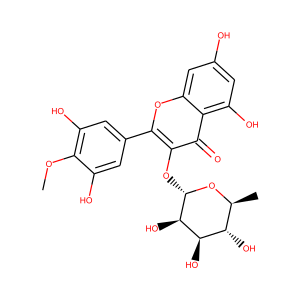

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: c1cc(c(cc1c1c(c(=O)c2c(cc(cc2o1)O)O)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](C(=O)O)O1)O)O)O)O)O
INCHIKEY: DUBCCGAQYVUYEU-ZUGPOPFOSA-N
--> Spec2Vec similarity score: 0.8289720093865028
--> Modified cosine score: 0.9847356486550037
With ground truth --> actual molecular similarity: 0.9336250911743253
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 53 ms: 10245/17062 bytes new/orig -> 60.0%


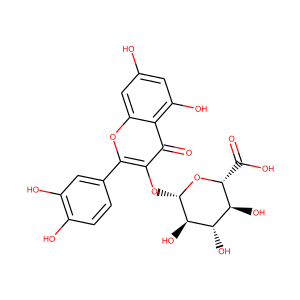

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: c1cc(c(cc1c1c(c(=O)c2c(cc(cc2o1)O)O)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](C(=O)O)O1)O)O)O)O)O
INCHIKEY: DUBCCGAQYVUYEU-ZUGPOPFOSA-N
--> Spec2Vec similarity score: 0.8164862267777125
--> Modified cosine score: 0.9529573983616093
With ground truth --> actual molecular similarity: 0.9336250911743253
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 60 ms: 10245/17062 bytes new/orig -> 60.0%


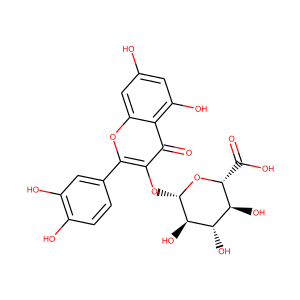

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: CCC(C)/C=C(\C)/C=C/C1=CC2=C(C(=O)C(C)(C(=O)C2=CN1CCCC(=O)O)OC(=O)C)Cl
INCHIKEY: SAMXBYLRDCRTCV-HMSDUJDUSA-N
--> Spec2Vec similarity score: 0.8059146610318765
--> Modified cosine score: 0.8913346672122187
With ground truth --> actual molecular similarity: 0.4608347627215552
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 31 ms: 9994/16315 bytes new/orig -> 61.3%


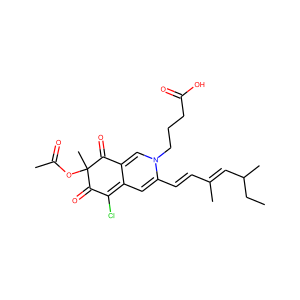

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: CC1(C)OC2COC3(COS(=O)(=O)N)C(C2O1)OC(C)(C)O3
INCHIKEY: KJADKKWYZYXHBB-UHFFFAOYSA-N
--> Spec2Vec similarity score: 0.7025888991831896
--> Modified cosine score: 0.7295436334381368
With ground truth --> actual molecular similarity: 0.3555404486743712
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 31 ms: 9965/15458 bytes new/orig -> 64.5%


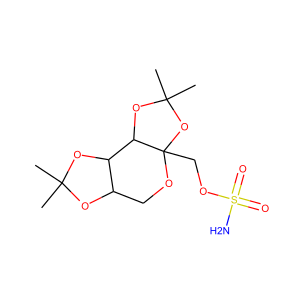

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: CC1(C)OC2COC3(COS(=O)(=O)N)C(C2O1)OC(C)(C)O3
INCHIKEY: KJADKKWYZYXHBB-UHFFFAOYSA-N
--> Spec2Vec similarity score: 0.7112140374766242
--> Modified cosine score: 0.6034312979645122
With ground truth --> actual molecular similarity: 0.3555404486743712
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 53 ms: 9965/15458 bytes new/orig -> 64.5%


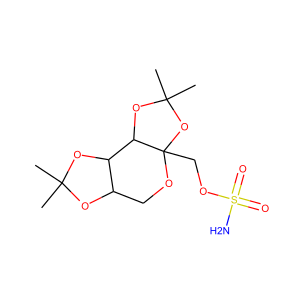

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)[C@H](CC[C@@H]3C[C@H](CC(=O)O3)O)[C@@H]12
INCHIKEY: PCZOHLXUXFIOCF-BXMDZJJMSA-N
--> Spec2Vec similarity score: 0.7708328087571585
--> Modified cosine score: 0.5720006586758507
With ground truth --> actual molecular similarity: 0.2617940199335548
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 31 ms: 7435/12801 bytes new/orig -> 58.1%


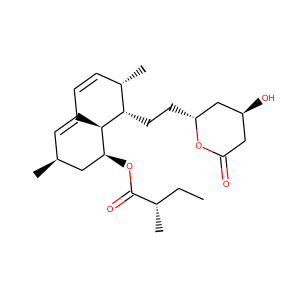

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: c1cc(c(cc1c1c(c(=O)c2c(cc(cc2o1)O)O)O[C@H]1[C@@H]([C@H]([C@@H]([C@@H](C(=O)O)O1)O)O)O)O)O
INCHIKEY: DUBCCGAQYVUYEU-ZUGPOPFOSA-N
--> Spec2Vec similarity score: 0.7285977743116886
--> Modified cosine score: 0.531147439222183
With ground truth --> actual molecular similarity: 0.9336250911743253
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 47 ms: 10245/17062 bytes new/orig -> 60.0%


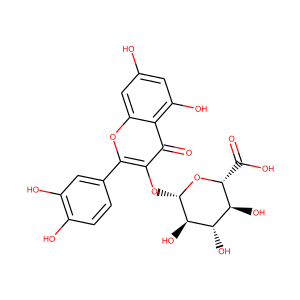

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: C/C(=C\Cc1c(c2c(COC2=O)c(C)c1OC)O)/C(CC(=O)O)O
INCHIKEY: OGJCZLOIKMTMKF-XBXARRHUSA-N
--> Spec2Vec similarity score: 0.7710446212934925
--> Modified cosine score: 0.4458846747392128
With ground truth --> actual molecular similarity: 0.35758706467661694
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 31 ms: 6883/11414 bytes new/orig -> 60.3%


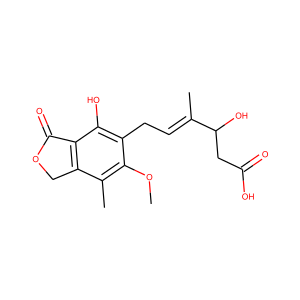

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: C/C(=C\Cc1c(c2c(COC2=O)c(C)c1OC)O)/C(CC(=O)O)O
INCHIKEY: OGJCZLOIKMTMKF-XBXARRHUSA-N
--> Spec2Vec similarity score: 0.7468491429474324
--> Modified cosine score: 0.30996020757950266
With ground truth --> actual molecular similarity: 0.35758706467661694
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 51 ms: 6883/11414 bytes new/orig -> 60.3%


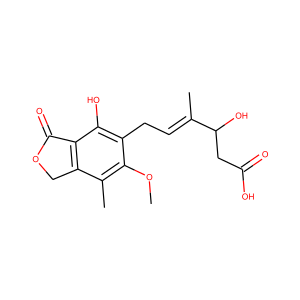

--------------------------------------------------------------------------------
SUGGESTED SIMILAR SPECTRA ------------------------------------------------------
SMILES: C1CN(CC[C@@]12C(N(Cc1cccc3ccccc13)C(N2)=O)=O)Cc1cc2c(cc1[Cl])OCO2
INCHIKEY: JTLODDSXLLEHRW-UHFFFAOYSA-N
--> Spec2Vec similarity score: 0.793652657593629
--> Modified cosine score: 0.02535369667667443
With ground truth --> actual molecular similarity: 0.42985611510791366
--> MOLECULES:
Scour processed file "draw_mols_temp.svg" in 70 ms: 10890/17885 bytes new/orig -> 60.9%


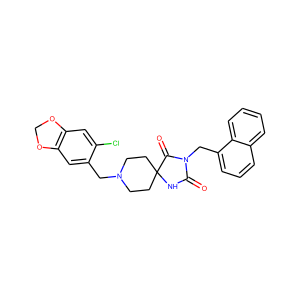

In [391]:
ID = 230
#positive: 70, 90
#somewhat revealing: 60, 130
#negative: 120, 210

#positive 100, 140, 500, 800, 40, 90, 175/180, 225, 350
#'negative' 20, 80, 160  (small molecules: 190)
#somewhat revealing: 170, 200

"""selected_matches = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.5)
                                  & (found_matches[ID]['modcosine_score'] > 0.5)]"""
"""selected_matches = found_matches[ID][((found_matches[ID]['mass_match_10ppm']==1)
                                 & (found_matches[ID]['modcosine_score'] > 0.5))
                                 | ((found_matches[ID]['S2V_top_n']==1)
                                  & (found_matches[ID]['S2V_similarity'] > 0.6))]"""
#selected_matches = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
#                                  & ((found_matches[ID]['S2V_similarity']+found_matches[ID]['modcosine_score']) > 1.2)]
selected_matches = found_matches[ID][(found_matches[ID]['S2V_top_n']==1)
                                  & ((found_matches[ID]['S2V_similarity'] > 0.6)
                                   | (found_matches[ID]['modcosine_score'] > 0.8))]


match_IDs = selected_matches['spectra_ID'].values.tolist()
match_S2V_scores = selected_matches['S2V_similarity'].values.tolist()
match_modcos_scores = selected_matches['modcosine_score'].values.tolist()

if len(match_IDs) > 0:
    smiles = spectra_unknown[ID].smiles
    
    print(40 * '--')
    print('QUERY SPECTRUM  ' + 32 * '--')
    print("SMILES:", smiles)
    print("INCHIKEY:", spectra_unknown[ID].inchikey)
    print('--> MOLECULE:')
    plot_molecule(smiles)
    
        
    fingerprint_query, _ = MS_functions.get_mol_fingerprints([spectra_unknown[ID]], 
                                                                 method = "daylight", #morgan3", 
                                                                 nBits = 2048,
                                                                 print_progress = False)
    fingerprint_matches, _ = MS_functions.get_mol_fingerprints([spectra_library[x] for x in match_IDs], 
                                                                 method = "daylight", #morgan3",
                                                                 nBits = 2048,
                                                                 print_progress = False)
    
    # Calculate molecular similarities
    Mtest = MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                           fingerprint_matches,
                                           method = 'jaccard',
                                           filename = None,
                                           max_size = 1000,
                                           print_progress = False)
    
    for i in np.array(match_modcos_scores).argsort()[::-1]:
        matchID = match_IDs[i]
        library_ID = library_spectra_metadata.iloc[matchID][0]
        smiles = spectra[library_ID].smiles

        print(40 * '--')
        print('SUGGESTED SIMILAR SPECTRA ' + 27 * '--')
        print("SMILES:", smiles)
        print("INCHIKEY:", spectra[library_ID].inchikey)
        print("--> Spec2Vec similarity score:", match_S2V_scores[i])
        print("--> Modified cosine score:", match_modcos_scores[i])
        print("With ground truth --> actual molecular similarity:", Mtest[0][i])
        print('--> MOLECULES:')
        plot_molecule(smiles)
else:
    print('No matches found with given search criteria!')

In [38]:
filename = "draw_mols_temp.svg"

mol = Chem.MolFromSmiles("[H][C@]1(CC(/C=C/C)=CN21)C(O)NC3=C(O)C(C)=C(O[C@@H]4O[C@@H](C)[C@H](NC)[C@@](C)(O)[C@H]4O)C=C3C2=O")

#Draw.MolToMPL(mol, size=(100, 100), kekulize=True, wedgeBonds=True, imageType=None, fitImage=True)
Draw.MolToFile(mol, filename)
!scour -i draw_mols_temp.svg -o draw_mols_temp_corr.svg

SVG(filename='draw_mols_temp_corr.svg')

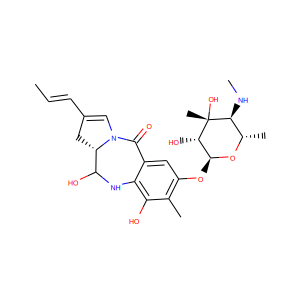

In [29]:
from IPython.core.display import SVG
SVG(filename=PATH_OUTPUT + "draw_mols.svg")

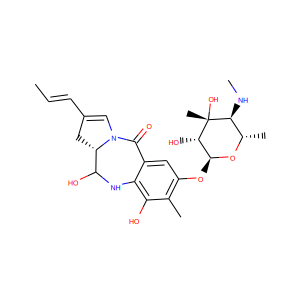

In [19]:
from IPython.display import SVG, display
def show_svg(file):
    display(SVG(filename = file))
    
show_svg(filename)

## Quick test about merging fingerprints... probably won't work

In [126]:
[np.sum(x) for x in fingerprint_matches]

[377, 85, 85, 85, 255, 255, 169, 169]

In [141]:
fingerprint_merged = np.mean(fingerprint_matches, axis =0)
fingerprint_merged[:80]

array([0.3, 0.4, 0.2, 0.3, 0. , 0.6, 0.1, 0.3, 0.4, 0.3, 0.2, 0.3, 0.6,
       0. , 0. , 0.2, 0.2, 0.1, 0.1, 0.2, 0.1, 0. , 0.1, 0.2, 0.8, 0.3,
       0.1, 0.3, 0.3, 0.2, 0.2, 0. , 0.3, 0. , 0. , 0.4, 0. , 0.1, 0.2,
       0.2, 0.2, 0.5, 0.1, 0.1, 0.2, 0. , 0.2, 0.5, 0.2, 0.3, 0.4, 0. ,
       0.2, 0.1, 0.1, 0. , 0.4, 0. , 0.6, 0.4, 0. , 0.2, 0.2, 0.2, 0.3,
       0.2, 0.5, 0.2, 0.5, 0.4, 0.2, 0.4, 0.3, 0. , 0. , 0.3, 0.1, 0.2,
       0. , 0.4])

In [142]:
[np.sum(fingerprint_merged>x) for x in [0.1, 0.2, 0.3, 0.4]]

[1380, 803, 503, 251]

In [143]:
np.mean(fingerprint_merged[fingerprint_merged>0])

0.2946666666666667

In [148]:
fingerprint_merged_bit = 1*(fingerprint_merged > 0.2)
fingerprint_merged_bit[:80]

array([1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [149]:
MS_sim_classic.mol_sim_matrix(fingerprint_query,
                                           [fingerprint_merged_bit, fingerprint_matches[0]],
                                           method = 'jaccard',
                                           filename = None,
                                           max_size = 1000,
                                           print_progress = False)

array([[0.15462869, 0.15432649]])